<a href="https://colab.research.google.com/github/rondinellimorais/chess_recognition/blob/notebooks/chess_board_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Find the playable area of the board

<img src="https://github.com/rondinellimorais/chess_recognition/raw/master/assets/img/board_mapping.png" />

# Setup

## Imports

In [ ]:
import math
from math import sqrt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spatial
import scipy.cluster as cluster
from collections import defaultdict
from statistics import mean
import imutils
from skimage import exposure
import argparse
import random

## Installs

In [ ]:
%%bash

rm -rf chess_boards/*

CHESS_BOARDS=(
  https://http2.mlstatic.com/D_NQ_NP_748199-MLB26339918146_112017-O.jpg
  https://docs.opencv.org/3.4/calib_result.jpg
  http://www.raspberryturk.com/assets/img/viewfromturk.jpg
  https://i.stack.imgur.com/2Bfo4.png
  https://raw.githubusercontent.com/Vatsalparsaniya/Realtime-OpenCV-Chess/master/Images/input-frame.png
  https://cdn.awsli.com.br/600x450/196/196972/produto/27839427/5a9104d09e.jpg
  https://images-americanas.b2w.io/produtos/01/00/img/1862120/4/1862120461_1GG.jpg
  https://cdn.awsli.com.br/600x450/1191/1191738/produto/53841260/1b43134485.jpg
  https://http2.mlstatic.com/D_NQ_NP_610754-MLB26120868149_102017-O.jpg
  https://cdn.awsli.com.br/600x450/196/196972/produto/27793967/bdd9a40b72.jpg
  https://previews.123rf.com/images/mirexon/mirexon1405/mirexon140500053/28129762-chess-board-and-chess-pieces-top-view.jpg
  https://http2.mlstatic.com/D_NQ_NP_730321-MLB20743400475_052016-O.jpg
)

for i in ${!CHESS_BOARDS[@]}; do
  CHESS_BOARD_URL=${CHESS_BOARDS[i]}
  mkdir -p chess_boards/$i
  wget -O chess_boards/$i/chess_board.jpg $CHESS_BOARD_URL
done

--2020-12-28 18:48:48--  https://raw.githubusercontent.com/rondinellimorais/chess_recognition/main/assets/camera_frame/00.jpg?token=AA6NQZM2IW5EWQ6XJ3QMAKS75IUI6
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-12-28 18:48:48 ERROR 404: Not Found.

--2020-12-28 18:48:48--  https://http2.mlstatic.com/D_NQ_NP_748199-MLB26339918146_112017-O.jpg
Resolving http2.mlstatic.com (http2.mlstatic.com)... 104.119.189.177, 104.119.189.185
Connecting to http2.mlstatic.com (http2.mlstatic.com)|104.119.189.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45234 (44K) [image/jpeg]
Saving to: ‘chess_boards/1/chess_board.jpg’

     0K .......... .......... .......... .......... ....      100% 2.84M=0.02s

Last-modified header invalid -- time-stamp ign

## Constants

In [ ]:
CHESSBOARD_FILE_PATH = '/content/daise.jpg'
PADDING = (15, 20)
NEED_ROTATE = True
NEED_PADDING = True
OUTPUT_IMAGE_SIZE = (500, 500)

## Helper functions

### random_color

In [ ]:
def random_color():
  """
  Generate a random color
  """
  color = list(np.random.choice(range(256), size=3))
  return (int(color[0]), int(color[1]), int(color[2]))

### rotate_image

In [ ]:
def rotate_image(image, angle):
  # Grab the dimensions of the image and then determine the center
  (h, w) = image.shape[:2]
  (cX, cY) = (w / 2, h / 2)

  # grab the rotation matrix (applying the negative of the
  # angle to rotate clockwise), then grab the sine and cosine
  # (i.e., the rotation components of the matrix)
  M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
  cos = np.abs(M[0, 0])
  sin = np.abs(M[0, 1])

  # Compute the new bounding dimensions of the image
  nW = int((h * sin) + (w * cos))
  nH = int((h * cos) + (w * sin))

  # Adjust the rotation matrix to take into account translation
  M[0, 2] += (nW / 2) - cX
  M[1, 2] += (nH / 2) - cY

  # Perform the actual rotation and return the image
  return cv2.warpAffine(image, M, (nW, nH))

### order_points_clockwise

In [ ]:
def order_points_clockwise(pts):
  # sort the points based on their x-coordinates
  xSorted = pts[np.argsort(pts[:, 0]), :]

  # grab the left-most and right-most points from the sorted
  # x-roodinate points
  leftMost = xSorted[:2, :]
  rightMost = xSorted[2:, :]

  # now, sort the left-most coordinates according to their
  # y-coordinates so we can grab the top-left and bottom-left
  # points, respectively
  leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
  (tl, bl) = leftMost

  # now, sort the right-most coordinates according to their
  # y-coordinates so we can grab the top-right and bottom-right
  # points, respectively
  rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
  (tr, br) = rightMost

  # return the coordinates in top-left, top-right,
  # bottom-right, and bottom-left order
  return np.array([tl, tr, br, bl], dtype="int32")

### perspective_transform

In [ ]:
def perspective_transform(image, corners):
  def order_corner_points(corners):
    # Separate corners into individual points
    # Index 0 - top-right
    #       1 - top-left
    #       2 - bottom-left
    #       3 - bottom-right
    corners = [(corner[0][0], corner[0][1]) for corner in corners]
    top_r, top_l, bottom_l, bottom_r = corners[0], corners[1], corners[2], corners[3]
    return (top_l, top_r, bottom_r, bottom_l)

  # Order points in clockwise order
  ordered_corners = order_corner_points(corners)
  top_l, top_r, bottom_r, bottom_l = ordered_corners

  # Determine width of new image which is the max distance between 
  # (bottom right and bottom left) or (top right and top left) x-coordinates
  width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
  width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
  width = max(int(width_A), int(width_B))

  # Determine height of new image which is the max distance between 
  # (top right and bottom right) or (top left and bottom left) y-coordinates
  height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
  height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
  height = max(int(height_A), int(height_B))

  # Construct new points to obtain top-down view of image in 
  # top_r, top_l, bottom_l, bottom_r order
  dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], 
                  [0, height - 1]], dtype = "float32")

  # Convert to Numpy format
  ordered_corners = np.array(ordered_corners, dtype="float32")

  # Find perspective transform matrix
  matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

  # Return the transformed image
  return cv2.warpPerspective(image, matrix, (width, height))

### draw_chessboard_corner

In [ ]:
def draw_chessboard_corner(img, matrix):
  mapping_img = img.copy()
  colors = [(140,0,236), (145,45,102), (166,84,0), (239,174,0), (81,166,0), (63,198,141), (0,242,255), (29,148,247), (36,28,237)]
  for (idx, points) in enumerate(matrix):
    # draw horizontal line
    cv2.line(mapping_img, points[0], points[-1], colors[idx], 2)

    # draw diagonal line
    if idx > 0:
      cv2.line(mapping_img, matrix[idx - 1][-1], points[0], colors[idx], 1)

    # draw points
    for point in points:
      cv2.circle(mapping_img, point, 5, colors[idx], -1)

  return mapping_img

### distance

In [ ]:
def distance(p, q):
  return sqrt(sum((px - qx) ** 2.0 for px, qx in zip(p, q)))

### canny_edge

In [ ]:
# Canny edge detection
def canny_edge(img, sigma=0.33):
  v = np.median(img)
  lower = int(max(0, (1.0 - sigma) * v))
  upper = int(min(255, (1.0 + sigma) * v))
  edges = cv2.Canny(img, lower, upper)
  return edges

### hough_line

In [ ]:
# Hough line detection
def hough_line(edges, min_line_length=100, max_line_gap=10):
  lines = cv2.HoughLines(edges, 1, np.pi / 180, 125, min_line_length, max_line_gap)
  lines = np.reshape(lines, (-1, 2))
  return lines

### h_v_lines

In [ ]:
# Separate line into horizontal and vertical
def h_v_lines(lines):
  h_lines, v_lines = [], []
  for rho, theta in lines:
    if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
      v_lines.append([rho, theta])
    else:
      h_lines.append([rho, theta])
  return h_lines, v_lines

### line_intersections

In [ ]:
# Find the intersections of the lines
def line_intersections(h_lines, v_lines):
  points = []
  for r_h, t_h in h_lines:
    for r_v, t_v in v_lines:
      a = np.array([[np.cos(t_h), np.sin(t_h)], [np.cos(t_v), np.sin(t_v)]])
      b = np.array([r_h, r_v])
      inter_point = np.linalg.solve(a, b)
      points.append(inter_point)
  return np.array(points)

### cluster_points

In [ ]:
# Hierarchical cluster (by euclidean distance) intersection points
def cluster_points(points):
  dists = spatial.distance.pdist(points)
  single_linkage = cluster.hierarchy.single(dists)
  flat_clusters = cluster.hierarchy.fcluster(single_linkage, 15, 'distance')
  cluster_dict = defaultdict(list)
  for i in range(len(flat_clusters)):
    cluster_dict[flat_clusters[i]].append(points[i])
  cluster_values = cluster_dict.values()
  clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), cluster_values)
  return sorted(list(clusters), key=lambda k: [k[1], k[0]])

# Find game board area

Essa sessão irá encontrar o tabuleiro através classificação da maior área, após encontrar a maior área uma nova imagem recortada será gerada.

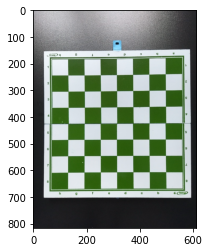

In [ ]:
image = cv2.imread(CHESSBOARD_FILE_PATH)
plt.imshow(image)

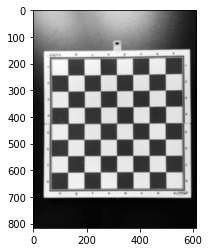

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

smooth = cv2.GaussianBlur(gray, (9, 9), 0)

plt.imshow(smooth, 'gray')

True

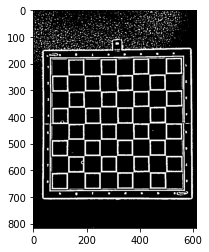

In [ ]:
thresh = cv2.adaptiveThreshold(smooth, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Since we're interested in the borders, and they are black, we invert the image color.
# Then, the borders of the chessboard are white (along with other noise).
thresh = cv2.bitwise_not(thresh)

kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=1)

plt.imshow(thresh, 'gray')
cv2.imwrite('resultado.jpg', thresh)

True

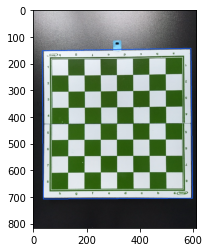

In [ ]:
# find biggest square area
cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse = True)

peri = cv2.arcLength(cnts[0], True)
biggest_cnt = cv2.approxPolyDP(cnts[0], 0.025 * peri, True)

imagedrawed = image.copy()
imagedrawed = cv2.drawContours(imagedrawed, [biggest_cnt], -1, random_color(), 2)

plt.imshow(imagedrawed)
cv2.imwrite('resultado.jpg', imagedrawed)

True

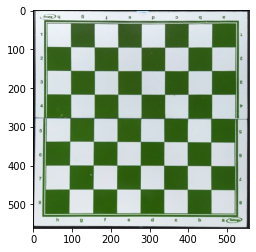

In [ ]:
transformed = perspective_transform(image.copy(), biggest_cnt)
plt.imshow(transformed)
cv2.imwrite('transformed.jpg', transformed)

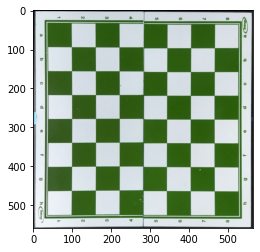

In [ ]:
if NEED_ROTATE:
  rotated = rotate_image(transformed, -90)
  plt.imshow(rotated)
  cv2.imwrite('rotated.jpg', rotated)

# Chessboard padding

O algoritmo da sessão **Find Game board area** trabalho com detecção do maior quadrado e depois realiza um crop na imagem realizando a correção da perspectiva.

**Exemplo**:

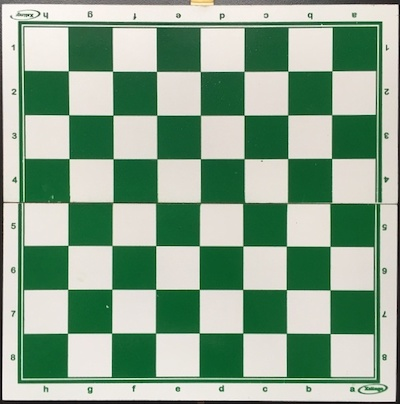

Essa é uma imagem já recortada após o mapeamento do tabuleiro.

Identificamos que o melhor a se fazer é adicionar um padding na imagem quando necessário para eliminar a possibilidade do mapeamento errado.

Não é sempre que a imagem irá precisar de padding, isso deve ficar sob escolha na hora de calibrar o tabuleiro.

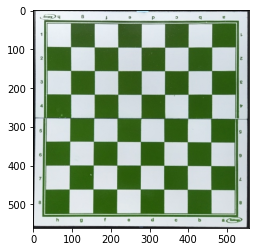

In [ ]:
img = cv2.imread('transformed.jpg')
plt.imshow(img)

In [ ]:
h, w = img.shape[:2]
padding_horizontal, padding_vertical = PADDING

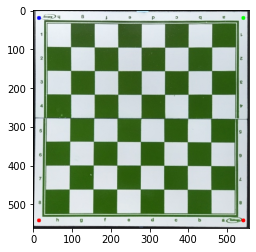

In [ ]:
imgcopied = img.copy()

cv2.circle(imgcopied, PADDING, 5, (0,0,255), -1)
cv2.circle(imgcopied, (w - padding_horizontal, padding_vertical), 5, (0,255,0), -1)

cv2.circle(imgcopied, (padding_horizontal, h - padding_vertical), 5, (255,0,0), -1)
cv2.circle(imgcopied, (w - padding_horizontal, h - padding_vertical), 5, (255,0,0), -1)

plt.imshow(imgcopied)

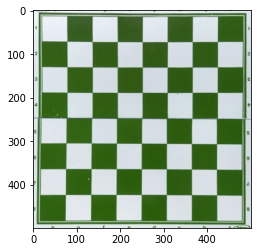

In [ ]:
if NEED_PADDING:
  output_img_h, output_img_w, = OUTPUT_IMAGE_SIZE

  pts1 = np.float32([
    PADDING,
    (w - padding_horizontal, padding_vertical),
    (padding_horizontal, h - padding_vertical),
    (w - padding_horizontal, h - padding_vertical)
  ])

  pts2 = np.float32([
  [0, 0],
  [output_img_w, 0],
  [0, output_img_h],
  [output_img_w, output_img_h]
  ])

  M = cv2.getPerspectiveTransform(pts1, pts2)
  dst = cv2.warpPerspective(img, M, OUTPUT_IMAGE_SIZE)

  plt.imshow(dst)
  cv2.imwrite('padding.jpg', dst)

# Find all chessboard corners


Identifica através de intersecção de linhas os cantos das casas

**Processo**

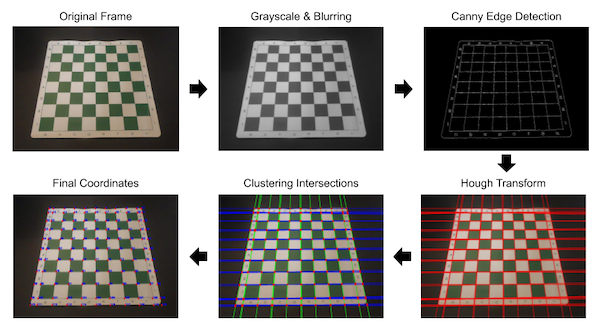

**Observação**

Esse algorítimo reconhece tbm os cantos do jogo de xadrez, para que ele funcione como esperado a imagem inputada deve remover os cantos do xadrez através de crop com pedding.

Na sessão **Chessboard padding** estou descrevendo melhor esse problema.

True

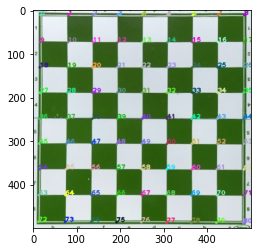

In [ ]:
# https://towardsdatascience.com/board-game-image-recognition-using-neural-networks-116fc876dafa
img = cv2.imread('padding.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Blur the image a little. This smooths out the noise a bit and
# makes extracting the grid lines easier.
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny algorithm
edges = canny_edge(gray_blur)

# Hough Transform
lines = hough_line(edges)

# Separate the lines into vertical and horizontal lines
h_lines, v_lines = h_v_lines(lines)

# Find and cluster the intersecting
intersection_points = line_intersections(h_lines, v_lines)
points = cluster_points(intersection_points)

# with index
for (idx, point) in enumerate(points):
  color = random_color()
  cv2.putText(img, str(idx), point, cv2.FONT_HERSHEY_PLAIN, 1.0, color, 2)
  cv2.circle(img, point, 3, color, -1)

# result
plt.imshow(img, 'gray')
cv2.imwrite('points_result.jpg', img)

In [ ]:
# tenho q começar de algum, será o 0
target_point = points[0]

# dependendo da imagem esse valor de threshold precisa mudar
thresh_val = 10.0
chess_matrix = []

while len(points) != 0:
  # pegue todas as coordenadas onde o y está entre min_thresh e max_thresh
  min_thresh = target_point[1] - thresh_val
  max_thresh = target_point[1] + thresh_val
  line_points = [p for p in points if p[1] >= min_thresh and p[1] <= max_thresh]
  line_points.sort(key=lambda p: p[0])

  # add points of the line into matrix
  if len(line_points) > 0:
    chess_matrix.append(line_points)

  # remove os pontos encontrados do array anterior
  points = [p for p in points if p not in line_points]

  # define o novo target point
  if len(points) != 0:
    target_point = points[0]

True

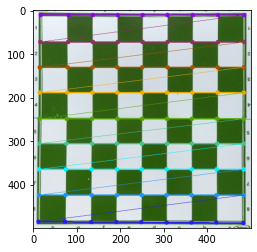

In [ ]:
img = cv2.imread('padding.jpg')
mapped = draw_chessboard_corner(img, chess_matrix)

# result
plt.imshow(mapped)
cv2.imwrite('chessboard_mapped.jpg', mapped)

# ROI slice chessboard

Através de técnicas de ordenação e threshold conseguimos ordenar e criar uma matriz do nosso tabuleiro (**chess_matrix**).

**Resultado**:

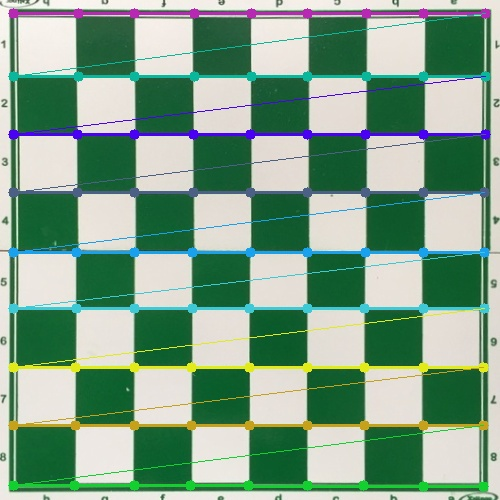

Com isso chegamos ao estágio final do problema: Recortar as casas de acordo com a matriz.

In [ ]:
!rm -rf casas
!mkdir casas

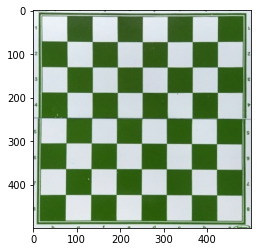

In [ ]:
img = cv2.imread('padding.jpg')
plt.imshow(img)

In [ ]:
# how to ROI crop works?
# ----------------
# (x1, y1)
#     •-------+
#     |  ROI  |
#     +-------•
#           (x2, y2)
for (row_idx, points) in enumerate(chess_matrix[:len(chess_matrix) - 1]):
  for (col_idx, pt1) in enumerate(points[:len(points) - 1]):
    pt2 = chess_matrix[row_idx + 1][col_idx + 1]

    x1 = round(pt1[0])
    y1 = round(pt1[1])
    x2 = round(pt2[0])
    y2 = round(pt2[1])

    cropped = img[y1:y2, x1:x2]
    cv2.imwrite('casas/{}_{}.jpg'.format(row_idx, col_idx), cropped)

# Identify square color

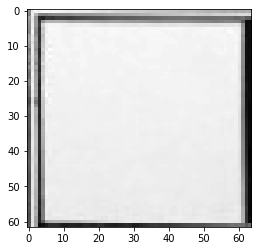

In [ ]:
img = cv2.imread('/content/casas/0_0.jpg')

# img = cropped
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, 'gray')

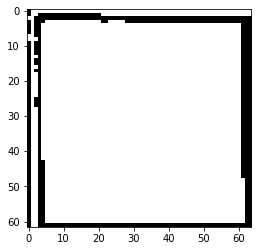

In [ ]:
# antes de realizar o ROI, vamos deixar a imagem 100% preta e branca
_, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_OTSU)
cv2.imwrite('thresh.jpg', thresh)
plt.imshow(thresh, 'gray')

In [ ]:
# print(thresh)
np.median(thresh) == 255.0 # branco

**Full test**

In [ ]:
for (row_idx, points) in enumerate(chess_matrix[:len(chess_matrix) - 1]):
  for (col_idx, point) in enumerate(points[:len(points) - 1]):
    house = cv2.imread("casas/{}_{}.jpg".format(row_idx, col_idx))
    gray = cv2.cvtColor(house, cv2.COLOR_BGR2GRAY)

    # antes de realizar o ROI, vamos deixar a imagem 100% preta e branca
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_OTSU)

    if np.median(thresh) == 255.0:
      cv2.putText(house, "BRANCO", (5, 30), cv2.FONT_HERSHEY_PLAIN, 1.0, (0,0,0), 2)
    else:
      cv2.putText(house, "PRETO", (5, 30), cv2.FONT_HERSHEY_PLAIN, 1.0, (255,255,255), 2)
    
    cv2.imwrite('casas/{}_{}.jpg'.format(row_idx, col_idx), house)

(Text(0.5, 1.0, 'casas/7_3.jpg'),
 <matplotlib.image.AxesImage at 0x7f2438024d30>)

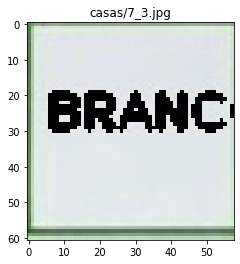

In [ ]:
from random import randint
file_name = "casas/{}_{}.jpg".format(randint(0, 7), randint(0, 7))
plt.title(file_name), plt.imshow(cv2.imread(file_name))